# Truora

# 1 Author

**Student Name**:  Zheyun Zhao

**Student ID**:  221170559



# 2 Problem formulation

Describe the machine learning problem that you want to solve and explain what's interesting about it.

# 3 Methodology

Describe your methodology. Specifically, describe your training task and validation task, and how model performance is defined (i.e. accuracy, confusion matrix, etc). Any other tasks that might help you build your model should also be described here.

In [23]:
import os
os.environ["KERAS_BACKEND"] = "torch"
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras import models, layers, callbacks
from typing import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import pandas as pd
import numpy as np
import joblib

In [24]:
class Config:
  def __init__(
      self,
      dataset_path: str = "../datasets/",
      story_path: str = "../datasets/CBU0521DD_stories/",
      augmented_story_path: str = "../datasets/CBU0521DD_stories/_augmented/",
      label_path: str = "../datasets/CBU0521DD_stories_attributes.csv",
      augmented_label_path: str = "../datasets/CBU0521DD_stories_attributes_augmented.csv",
      labels: List[str] = ["True Story", "Deceptive Story"],
      model_path: str = "../models/",
      epoch: int = 100,
      batch_size: int = 10,
      n_models:int = 3,
  ):
    self.dataset_path = dataset_path
    self.story_path = story_path
    self.augmented_story_path = augmented_story_path
    self.label_path = label_path
    self.augmented_label_path = augmented_label_path
    self.labels = labels
    self.model_path = model_path
    self.epoch = epoch
    self.batch_size = batch_size
    self.n_models = n_models

# 4 Implemented ML prediction pipelines

Describe the ML prediction pipelines that you will explore. Clearly identify their input and output, stages and format of the intermediate data structures moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. After providing an overview, describe in more detail each one of the stages that you have included in their corresponding subsections (i.e. 4.1 Transformation stage, 4.2 Model stage, 4.3 Ensemble stage).

## 4.1 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

In [25]:
class DataTransformer:
  """
  用于完成以下功能：
  1. 读取并加载数据（包括原始数据与增强数据）
  2. 对音频数据进行特征提取（Mel-Spectrogram, MFCC, Chroma等）
  3. 保存与加载NPZ格式的数据
  """

  def __init__(self, config: Config):
    self.config = config

  # Save features and labels to a .npz file
  def save_data(features, labels, file_path):
    np.savez(file_path, features=features, labels=labels)
    print(f"Dataset saved to: {file_path}")

  # 加载数据
  def load_data_from_npz(self, file_path):
    data = np.load(file_path)
    return data

  def load_data(self, dataset_path: str, labels_df: pd.DataFrame, augmented: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    filenames = self._get_filenames(labels_df, augmented)
    features, labels = [], []

    for filename in tqdm(filenames, desc="Loading data", ncols=100, unit="file"):
      file_path = os.path.join(dataset_path, filename)
      audio_features = self.extract_features(file_path)

      story_type = self._get_story_type(filename, labels_df, augmented)

      features.append(audio_features)
      labels.append(story_type)

    return {
      "features": np.array(features),
      "labels": np.array(labels),
    }

  def _get_filenames(self, labels_df: pd.DataFrame, augmented: bool) -> list:
    if augmented:
      augmented_labels_df = pd.read_csv(self.config.augmented_label_path)
      return augmented_labels_df["filename"].tolist()
    else:
      return labels_df["filename"].tolist()

  def _get_story_type(self, filename: str, labels_df: pd.DataFrame, augmented: bool) -> str:
    if augmented:
      augmented_labels_df = pd.read_csv(self.config.augmented_label_path)
      return augmented_labels_df[augmented_labels_df["filename"] == filename]["Story_type"].values[0]
    else:
      return labels_df[labels_df["filename"] == filename]["Story_type"].values[0]

  @staticmethod
  def extract_features(
      file_path: str,
      sr: int = 16000,
      n_mels: int = 128,
      duration: int = 240,
  ) -> np.ndarray:
    """
    提取音频特征，包括Mel-Spectrogram、MFCC、Chroma、ZCR、能量、持续时间、谱质心、滚降点等。
    最终将所有特征拼接到同一矩阵中，并做定长处理。
    """
    audio, sr = librosa.load(file_path, sr=sr)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    short_term_energy = np.sum(audio ** 2) / len(audio)
    duration_feature = len(audio) / sr

    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spectral_flux = librosa.onset.onset_strength(y=audio, sr=sr)

    features = np.vstack([
        log_mel_spectrogram,
        mfcc,
        chroma,
        zero_crossing_rate,
        spectral_centroid,
        spectral_rolloff,
        spectral_flux,
    ])

    target_length = int(sr * duration / 512)
    if features.shape[1] < target_length:
      padding = np.zeros((features.shape[0], target_length - features.shape[1]))
      features = np.concatenate([features, padding], axis=1)
    else:
      features = features[:, :target_length]

    additional_features = np.array([short_term_energy, duration_feature])
    additional_features = np.repeat(additional_features[:, np.newaxis], features.shape[1], axis=1)

    features = np.concatenate([features, additional_features], axis=0)

    return features

## 4.2 Model stage

Describe the ML model(s) that you will build. Explain why you have chosen them.

In [26]:
class ModelBuilder:
  """
  负责构建与返回所需模型。
  目前包含：CNN-LSTM模型（带Attention）以及随机森林模型。
  """

  def build_cnn_lstm_model(self, input_shape: Tuple[int, int, int]) -> models.Model:
    model_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Reshape((1, 128))(x)  # (batch_size, sequence_length=1, feature_dim=128)
    attention_output = layers.Attention()([x, x])  # Self-Attention

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(attention_output)
    x = layers.Bidirectional(layers.LSTM(64))(x)

    x = layers.Dense(64, activation="relu", kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=model_input, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

  @staticmethod
  def build_rf_model(random_state: int = 42, n_estimators: int = 100) -> RandomForestClassifier:
    return RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
  
  @staticmethod
  def build_knn_model(n_neighbors: int = 3) -> KNeighborsClassifier:
    return KNeighborsClassifier(n_neighbors=n_neighbors)

In [27]:
class Trainer:
  """
  负责模型的训练与可视化（如Loss、Accuracy曲线）。
  """

  def __init__(self, config: Config, model_builder: ModelBuilder):
    self.config = config
    self.model_builder = model_builder

  @staticmethod
  def show_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

  def train(
      self,
      num_of_models: int,
      X_train: np.ndarray,
      y_train: np.ndarray,
      X_val: np.ndarray,
      y_val: np.ndarray,
      continue_training: bool = False
  ) -> models.Model:
    """
    训练多个CNN-LSTM模型（集成），或加载已有模型继续训练。
    """
    if continue_training:
      print(f"Continue Training Model {num_of_models}")
      model = models.load_model(os.path.join(self.config.model_path, f"best_model_{num_of_models}.keras"))
    else:
      print(f"Training Model {num_of_models}")
      model = self.model_builder.build_cnn_lstm_model(
          (X_train.shape[1], X_train.shape[2], X_train.shape[3])
      )

    early_stopping = callbacks.EarlyStopping(monitor="loss", patience=100)
    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=os.path.join(self.config.model_path, f"best_model_{num_of_models}.keras"),
        monitor="val_accuracy",
        save_best_only=True
    )
    callbacks_list = [early_stopping, model_checkpoint]

    history = model.fit(
        X_train,
        y_train,
        epochs=self.config.epoch,
        batch_size=self.config.batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list
    )
    self.show_history(history)

    return model

  def train_random_forest(self, X_train: np.ndarray, y_train: np.ndarray) -> RandomForestClassifier:
    """
    训练随机森林模型。
    """
    rf_model = self.model_builder.build_rf_model()
    # 对高维特征进行降维处理，展开为2D
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    rf_model.fit(X_train_2d, y_train)
    return rf_model
  
  def train_knn(self, X_train: np.ndarray, y_train: np.ndarray) -> KNeighborsClassifier:
    """
    训练KNN模型。
    """
    knn_model = self.model_builder.build_knn_model()
    # 对高维特征进行降维处理，展开为2D
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    knn_model.fit(X_train_2d, y_train)
    return knn_model

In [28]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str]):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.title("Confusion Matrix")
  plt.show()


def plot_roc_curve(y_true: np.ndarray, y_pred_prob: np.ndarray):
  fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
  plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
  plt.xlabel("1 - Specificity (FPR)")
  plt.ylabel("Sensitivity (TPR)")
  plt.title("Receiver Operating Characteristic (ROC) Curve")
  plt.legend(loc="lower right")
  plt.show()

## 4.3 Ensemble stage

Describe any ensemble approach you might have included. Explain why you have chosen them.

In [29]:
class Predictor:
  """
  用于模型预测及输出结果。包含集成预测的方法。
  """
  @staticmethod
  def ensemble_predict(
      X_test: np.ndarray,
      model_list: Optional[List[models.Model]] = None,
      rf_model: Optional[RandomForestClassifier] = None,
      knn_model: Optional[KNeighborsClassifier] = None,
      weights: Optional[List[float]] = None
  ) -> Tuple[np.ndarray, np.ndarray]:
    if model_list is None and rf_model is None and knn_model is None:
      raise ValueError("At least one model is required!")

    predictions = []
    prediction_weights = []

    if model_list is not None:
      nn_preds = np.zeros((len(model_list), X_test.shape[0]))
      for i, model in enumerate(model_list):
        nn_preds[i] = model.predict(X_test).flatten()
      nn_pred_avg = np.mean(nn_preds, axis=0)
      predictions.append(nn_pred_avg)
      print(f"NN Predictions: {nn_pred_avg}")

    if rf_model is not None:
      X_test_2d = X_test.reshape(X_test.shape[0], -1)
      rf_preds = rf_model.predict_proba(X_test_2d)[:, 1]
      predictions.append(rf_preds)
      print(f"RF Predictions: {rf_preds}")

    if knn_model is not None:
      X_test_2d = X_test.reshape(X_test.shape[0], -1)
      knn_preds = knn_model.predict(X_test_2d)
      predictions.append(knn_preds)
      print(f"KNN Predictions: {knn_preds}")

    num_sources = len(predictions)
    if weights is None:
      weights = [1.0 / num_sources] * num_sources
    elif len(weights) != num_sources:
      raise ValueError("The number of weights must match the number of models used for prediction!")

    final_pred_prob = np.average(predictions, axis=0, weights=weights)
    final_pred = (final_pred_prob > 0.5).astype(int)

    return final_pred, final_pred_prob

In [30]:
class Evaluator:
  """
  对模型进行评估，包括指标计算、混淆矩阵与ROC曲线绘制等。
  """
  @staticmethod
  def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

  def evaluate_ensemble_model(
      self,
      *,
      X_test: np.ndarray,
      y_true: np.ndarray,
      labels: List[str],
      model_list: Optional[List[models.Model]] = None,
      rf_model: Optional[RandomForestClassifier] = None,
      knn_model: Optional[KNeighborsClassifier] = None
  ) -> Tuple[np.ndarray, np.ndarray]:
    final_pred, final_pred_prob = Predictor.ensemble_predict(X_test=X_test, model_list=model_list, rf_model=rf_model, knn_model=knn_model)
    print("\nEnsemble Model Evaluation:")
    self.evaluate_model(y_true, final_pred)
    plot_confusion_matrix(y_true, final_pred, labels=labels)
    plot_roc_curve(y_true, final_pred_prob)
    return final_pred, final_pred_prob

# 5 Dataset

Describe the datasets that you will create to build and evaluate your models. Your datasets need to be based on our MLEnd Deception Dataset. After describing the datasets, build them here. You can explore and visualise the datasets here as well. 

If you are building separate training and validatio datasets, do it here. Explain clearly how you are building such datasets, how you are ensuring that they serve their purpose (i.e. they are independent and consist of IID samples) and any limitations you might think of. It is always important to identify any limitations as early as possible. The scope and validity of your conclusions will depend on your ability to understand the limitations of your approach.

If you are exploring different datasets, create different subsections for each dataset and give them a name (e.g. 5.1 Dataset A, 5.2 Dataset B, 5.3 Dataset 5.3) .



In [45]:
import soundfile as sf

CONFIG = {
    "dataset_path": "../datasets/",
    "story_path": "../datasets/CBU0521DD_stories/",
    "label_path": "../datasets/CBU0521DD_stories_attributes.csv",
}

In [46]:
# Data augmentation methods: time stretch, pitch shift, add noise, change volume
def time_stretch(y, rate=1.2):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, n_steps=4):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_level=0.005):
    noise = np.random.randn(len(y))
    return y + noise_level * noise

def change_volume(y, factor=1.2):
    return y * factor

def process_audio(filename, story_path, sr=16000):
    y, _ = librosa.load(os.path.join(story_path, filename), sr=sr)
    
    augmented_audios = []
    augmented_audios.append(time_stretch(y))
    augmented_audios.append(pitch_shift(y, sr))
    augmented_audios.append(add_noise(y))
    augmented_audios.append(change_volume(y))

    return [y] + augmented_audios

In [47]:
# 读取标签文件
label_df = pd.read_csv(CONFIG['label_path'])
filenames = label_df['filename'].tolist()

filenames[:5]

['00001.wav', '00002.wav', '00003.wav', '00004.wav', '00005.wav']

In [48]:
augmented_filenames = []
augmented_labels = []

# 增强后的音频存储路径
augmented_story_path = CONFIG['story_path'] + "_augmented/"
if not os.path.exists(augmented_story_path):
    os.makedirs(augmented_story_path)

In [49]:
# 遍历每个音频文件，进行数据增强
for filename in tqdm(filenames, desc="Processing audio files", unit="file"):
    # 处理原始音频及其增强版本
    augmented_audios = process_audio(filename, CONFIG['story_path'])

    for i, y in enumerate(augmented_audios):
        augmented_filename = filename.split('.')[0] + f"_augmented_{i}.wav"
        augmented_filenames.append(augmented_filename)
        augmented_labels.append(label_df[label_df['filename'] == filename]['Story_type'].values[0])

        # 保存增强后的音频
        sf.write(os.path.join(augmented_story_path, augmented_filename), y, 16000)

Processing audio files: 100%|██████████| 100/100 [02:49<00:00,  1.69s/file]


In [50]:
# 更新标签文件
augmented_labels_df = pd.DataFrame({
    "filename": augmented_filenames,
    "Language": ['Chinese'] * len(augmented_filenames),
    "Story_type": augmented_labels
})

# 保存新的标签文件
augmented_labels_df.to_csv(CONFIG['label_path'].replace('.csv', '_augmented.csv'), index=False)

print(f"Data augmentation complete. The new label file is saved at: {CONFIG['label_path'].replace('.csv', '_augmented.csv')}")

Data augmentation complete. The new label file is saved at: ../datasets/CBU0521DD_stories_attributes_augmented.csv


# 6 Experiments and results

Carry out your experiments here. Analyse and explain your results. Unexplained results are worthless.

In [31]:
class Pipeline:
  def __init__(self, config: Config, data_transformer: DataTransformer = None, model_builder: ModelBuilder = None, trainer: Trainer = None, evaluator: Evaluator = None, predictor: Predictor = None):
    self.config = config
    self.nn_models = None
    self.rf_model: RandomForestClassifier = None
    self.knn_model: KNeighborsClassifier = None
    self.use_nn: bool = True
    self.use_rf: bool = True
    self.use_knn: bool = True
    self.data_transformer = data_transformer
    self.model_builder = model_builder
    self.trainer = trainer
    self.evaluator = evaluator
    self.predictor = predictor

  def enable_nn(self):
    self.use_nn = True

  def disable_nn(self):
    self.use_nn = False

  def enable_rf(self):
    self.use_rf = True

  def disable_rf(self):
    self.use_rf = False

  def enable_knn(self):
    self.use_knn = True

  def disable_knn(self):
    self.use_knn = False

  def load_nn_models(self, model_path: List[str]):
    self.nn_models = [models.load_model(path) for path in model_path]

  def load_rf_model(self, model_path: str):
    self.rf_model = joblib.load(model_path)

  def load_knn_model(self, model_path: str):
    self.knn_model = joblib.load(model_path)

  def pre_process(self, load_from_npz: bool = False, augmented: bool = False):
      if load_from_npz:
          original_data = self.data_transformer.load_data_from_npz(os.path.join(self.config.dataset_path, "original_data.npz"))
          augmented_data = self.data_transformer.load_data_from_npz(os.path.join(self.config.dataset_path, "augmented_data.npz")) if augmented else None
      else:
          labels_df = pd.read_csv(self.config.label_path)
          original_data = self.data_transformer.load_data(self.config.story_path, labels_df, augmented=False)
          augmented_data = self.data_transformer.load_data(self.config.augmented_story_path, labels_df, augmented=True) if augmented else None

      datasets = []

      for i in range(self.config.n_models):
          # Bootstrap sampling
          if augmented and augmented_data is not None:
              sampled_idx_original = np.random.choice(original_data['features'].shape[0], original_data['features'].shape[0], replace=True)
              sampled_idx_augmented = np.random.choice(augmented_data['features'].shape[0], augmented_data['features'].shape[0], replace=True)

              sampled_original_features = original_data['features'][sampled_idx_original]
              sampled_original_labels = original_data['labels'][sampled_idx_original]

              sampled_augmented_features = augmented_data['features'][sampled_idx_augmented]
              sampled_augmented_labels = augmented_data['labels'][sampled_idx_augmented]

              features = np.concatenate((sampled_original_features, sampled_augmented_features), axis=0)
              labels = np.concatenate((sampled_original_labels, sampled_augmented_labels), axis=0)
          else:
              sampled_idx_original = np.random.choice(original_data['features'].shape[0], original_data['features'].shape[0], replace=True)

              features = original_data['features'][sampled_idx_original]
              labels = original_data['labels'][sampled_idx_original]

          # Split into 70% train, 15% validation, 15% test
          X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
          X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

          # Add new axis for compatibility with models
          X_train = X_train[..., np.newaxis]
          X_val = X_val[..., np.newaxis]
          X_test = X_test[..., np.newaxis]

          datasets.append((X_train, y_train, X_val, y_val, X_test, y_test))

      self.config.labels = np.unique(labels)

      print(f"Labels: {self.config.labels}")
      print(f"Original dataset size: {original_data['features'].shape[0]}")
      if augmented:
          print(f"Augmented dataset size: {augmented_data['features'].shape[0]}")
      print(f"Number of datasets created: {len(datasets)}")

      label_encoder = LabelEncoder()
      for i, (X_train, y_train, X_val, y_val, X_test, y_test) in enumerate(datasets):
          y_train_encoded = label_encoder.fit_transform(y_train)
          y_val_encoded = label_encoder.transform(y_val)
          y_test_encoded = label_encoder.transform(y_test)

          datasets[i] = (X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded)

      return datasets, label_encoder

  def nn_train(self, datasets, continue_training: bool = False):
      self.nn_models = []
      for i in range(self.config.n_models):
          X_train, y_train, X_val, y_val, _, _ = datasets[i]
          model = self.trainer.train(num_of_models=i+1, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, continue_training=continue_training)
          self.nn_models.append(model)

  def rf_train(self, X_train, y_train):
    self.rf_model = self.trainer.train_random_forest(X_train, y_train)
    joblib.dump(self.rf_model, os.path.join(self.config.model_path, "random_forest_model.joblib"))

  def knn_train(self, X_train, y_train):
    self.knn_model = self.trainer.train_knn(X_train, y_train)
    joblib.dump(self.knn_model, os.path.join(self.config.model_path, "knn_model.joblib"))

  def evaluate(self, label_encoder, X_test, y_test):
    labels = self.config.labels
    models_to_use = []

    if self.use_nn and self.nn_models is not None:
      models_to_use.append(self.nn_models)
    if self.use_rf and self.rf_model is not None:
      models_to_use.append(self.rf_model)
    if self.use_knn and self.knn_model is not None:
      models_to_use.append(self.knn_model)

    if not models_to_use:
      raise ValueError("At least one model (NN or RF) must be enabled for evaluation.")

    final_pred, final_pred_prob = self.evaluator.evaluate_ensemble_model(
        X_test=X_test,
        y_true=y_test,
        labels=labels,
        model_list=self.nn_models if self.use_nn else None,
        rf_model=self.rf_model if self.use_rf else None,
        knn_model=self.knn_model if self.use_knn else None
    )

    predicted_labels = label_encoder.inverse_transform(final_pred)
    true_labels = label_encoder.inverse_transform(y_test)
    for true, pred in zip(true_labels, predicted_labels):
      print(f"Actual: {true}, Predicted: {pred}")

In [32]:
config = Config(
    dataset_path="../datasets/",
    story_path="../datasets/CBU0521DD_stories/",
    augmented_story_path="../datasets/CBU0521DD_stories/_augmented/",
    label_path="../datasets/CBU0521DD_stories_attributes.csv",
    augmented_label_path="../datasets/CBU0521DD_stories_attributes_augmented.csv",
    model_path="../models/",
    epoch=100,
    batch_size=10,
    n_models=3,
)

data_transformer = DataTransformer(config)
model_builder = ModelBuilder()
trainer = Trainer(config, model_builder)
evaluator = Evaluator()
predictor = Predictor()

pipeline = Pipeline(config, data_transformer, model_builder, trainer, evaluator, predictor)

In [11]:
datasets, label_encoder = pipeline.pre_process(load_from_npz=True, augmented=True)

Labels: ['Deceptive Story' 'True Story']
Original dataset size: 100
Augmented dataset size: 500
Number of datasets created: 3


In [33]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets[0]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((420, 166, 7500, 1),
 (420,),
 (90, 166, 7500, 1),
 (90,),
 (90, 166, 7500, 1),
 (90,))

Training Model 1


Epoch 1/100


42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 408ms/step - accuracy: 0.5167 - loss: 1.4717 - val_accuracy: 0.5556 - val_loss: 1.2428
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.5982 - loss: 1.1765 - val_accuracy: 0.5556 - val_loss: 1.0599
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.4961 - loss: 1.0389 - val_accuracy: 0.5556 - val_loss: 0.9397
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 427ms/step - accuracy: 0.5600 - loss: 0.9202 - val_accuracy: 0.5556 - val_loss: 0.8613
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.6233 - loss: 0.7988 - val_accuracy: 0.5778 - val_loss: 0.8132
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - accuracy: 0.5546 - loss: 0.7963 - val_accuracy: 0.5778 - val_loss: 0.7792
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.6062 - loss: 0.7537 - val_accuracy: 0.5778 - val_loss: 0.7541
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.5943 - loss: 0.7298 - val_accuracy

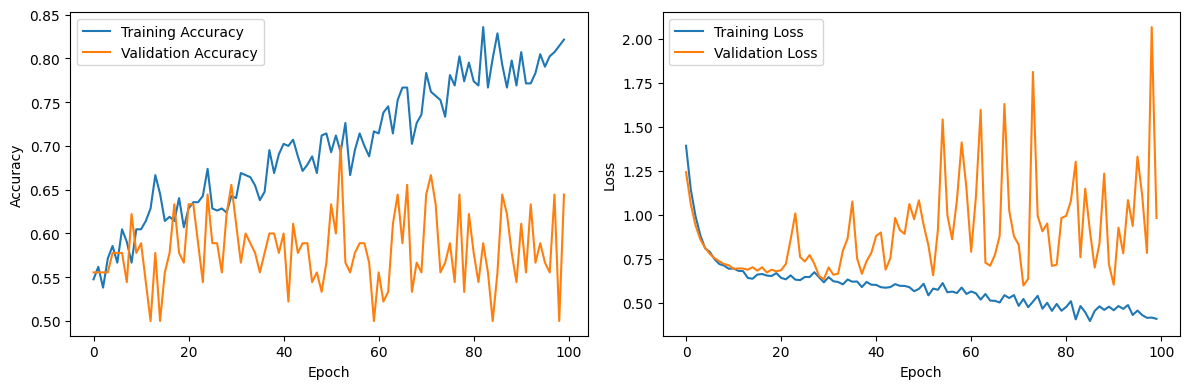

Training Model 2
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 505ms/step - accuracy: 0.5810 - loss: 1.4536 - val_accuracy: 0.4222 - val_loss: 1.2805
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - accuracy: 0.5408 - loss: 1.2303 - val_accuracy: 0.4222 - val_loss: 1.1047
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 478ms/step - accuracy: 0.5173 - loss: 1.0746 - val_accuracy: 0.4222 - val_loss: 0.9943
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - accuracy: 0.6024 - loss: 0.9365 - val_accuracy: 0.4222 - val_loss: 0.9159
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.6301 - loss: 0.8441 - val_accuracy: 0.4222 - val_loss: 0.8653
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 470ms/step - accuracy: 0.5823 - loss: 0.8409 - val_accuracy: 0.4222 - val_loss: 0.8195
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 488ms/step - accuracy: 0.6315 - loss: 0.7602 - val_accuracy: 0.4444 - val_loss: 0.7909
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 496ms/step - accuracy: 0.5332 

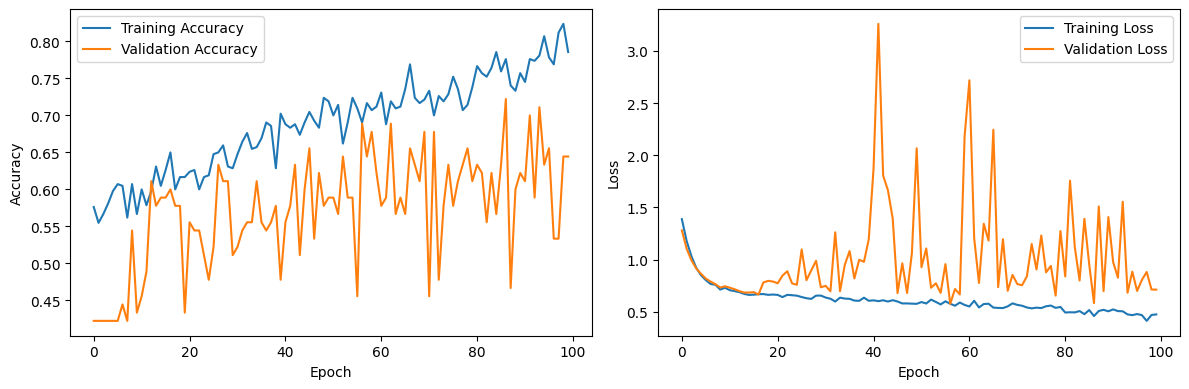

Training Model 3
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step - accuracy: 0.5537 - loss: 1.4777 - val_accuracy: 0.5111 - val_loss: 1.2530
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 341ms/step - accuracy: 0.6243 - loss: 1.1726 - val_accuracy: 0.5111 - val_loss: 1.0695
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - accuracy: 0.5983 - loss: 1.0058 - val_accuracy: 0.5111 - val_loss: 0.9538
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.5802 - loss: 0.9070 - val_accuracy: 0.5111 - val_loss: 0.8769
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - accuracy: 0.5956 - loss: 0.8415 - val_accuracy: 0.5111 - val_loss: 0.8225
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - accuracy: 0.6151 - loss: 0.7842 - val_accuracy: 0.5333 - val_loss: 0.7867
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.5763 - loss: 0.7657 - val_accuracy: 0.5333 - val_loss: 0.7581
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - accuracy: 0.6255 

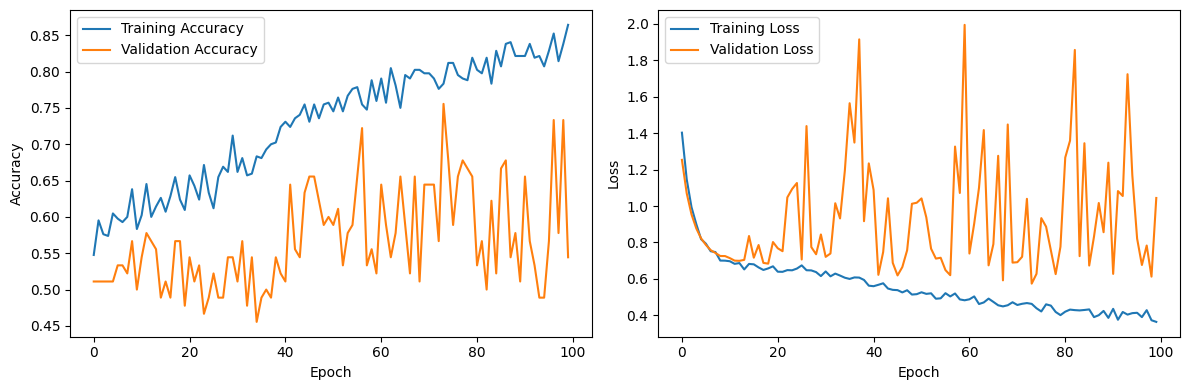

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 166, 7500, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 166, 7500, │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 166, 7500, │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 83, 3750,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 83, 3750,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 83, 3750,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 83, 3750,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 41, 1875,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 41, 1875,  │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 41, 1875,  │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 1875,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 128)    │          0 │ reshape[0][0],    │
│ (Attention)         │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1, 256)    │    263,168 │ attention[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,587,845 (6.06 MB)

 Trainable params: 529,089 (2.02 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 1,058,180 (4.04 MB)

In [13]:
pipeline.nn_train(datasets=datasets, continue_training=False)

nn_model_1 = models.load_model(os.path.join(config.model_path, "best_model_1.keras"))
nn_model_1.summary()

In [ ]:
keras.utils.plot_model(nn_model_1, show_shapes=True)

In [14]:
pipeline.rf_train(X_train, y_train)

In [34]:
pipeline.knn_train(X_train, y_train)

In [37]:
nn_models_path = [os.path.join(config.model_path, f"best_model_{i+1}.keras") for i in range(config.n_models)]
pipeline.load_nn_models(nn_models_path)

In [38]:
pipeline.load_rf_model(os.path.join(pipeline.config.model_path, "random_forest_model.joblib"))

In [39]:
pipeline.load_knn_model(os.path.join(pipeline.config.model_path, "knn_model.joblib"))

In [40]:
pipeline.nn_models, pipeline.rf_model, pipeline.knn_model

([<Functional name=functional, built=True>,
  <Functional name=functional_1, built=True>,
  <Functional name=functional_2, built=True>],
 RandomForestClassifier(random_state=42),
 KNeighborsClassifier(n_neighbors=3))

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
NN Predictions: [0.19905363 0.35986781 0.22247695 0.17041216 0.69472067 0.72183309
 0.46440175 0.38530237 0.18614165 0.17145137 0.9847918  0.10404564
 0.78115195 0.16903633 0.23857057 0.19601264 0.7861897  0.20673722
 0.89477086 0.7759831  0.18590164 0.54238917 0.18590164 0.65104777
 0.17725977 0.06564186 0.65498604 0.5262412  0.30828029 0.67677205
 0.71140675 0.69472067 0.10404564 0.37980154 0.52088497 0.52541719
 0.41187574 0.22232869 0.35990674 0.82570972 0.65407383 0.48291641
 0.99282696 0.38354321 0.24649067 0.7861897  0.96878294 0.52283607
 0.49896491 0.71603944 0.48263709 0.98560556 0.31692346 0.6062819
 0.14824082 0.22868636 0.22927345 0.30934682 0.50603817 0.60783932
 0.91973499 0.25217604 0.23857057 0.82470894 0.55806717 0.45504762
 0.72771456 0.47822981 0.76498063 0.40402419 0.7583093  0.20685283
 0.58902035 0.84770759 0.25861018 0.49477662 0.80771597 0.720593

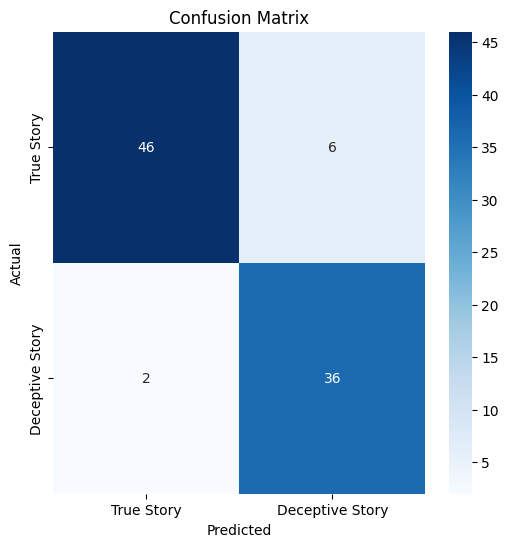

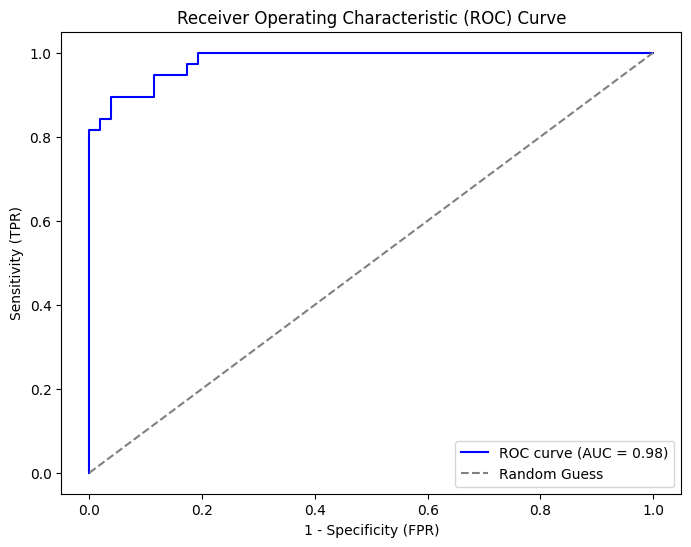

Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive

In [41]:
pipeline.enable_nn()
pipeline.enable_rf()
pipeline.enable_knn()
pipeline.evaluate(label_encoder, X_test, y_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
NN Predictions: [0.19905363 0.35986781 0.22247695 0.17041216 0.69472067 0.72183309
 0.46440175 0.38530237 0.18614165 0.17145137 0.9847918  0.10404564
 0.78115195 0.16903633 0.23857057 0.19601264 0.7861897  0.20673722
 0.89477086 0.7759831  0.18590164 0.54238917 0.18590164 0.65104777
 0.17725977 0.06564186 0.65498604 0.5262412  0.30828029 0.67677205
 0.71140675 0.69472067 0.10404564 0.37980154 0.52088497 0.52541719
 0.41187574 0.22232869 0.35990674 0.82570972 0.65407383 0.48291641
 0.99282696 0.38354321 0.24649067 0.7861897  0.96878294 0.52283607
 0.49896491 0.71603944 0.48263709 0.98560556 0.31692346 0.6062819
 0.14824082 0.22868636 0.22927345 0.30934682 0.50603817 0.60783932
 0.91973499 0.25217604 0.23857057 0.82470894 0.55806717 0.45504762
 0.72771456 0.47822981 0.76498063 0.40402419 0.7583093  0.20685283
 0.58902035 0.84770759 0.25861018 0.49477662 0.80771597 0.720593

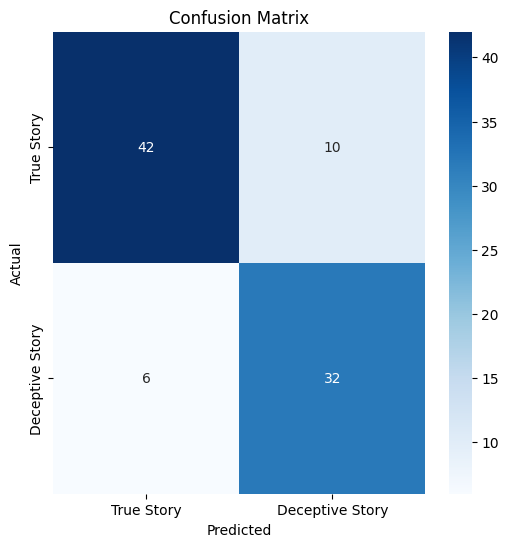

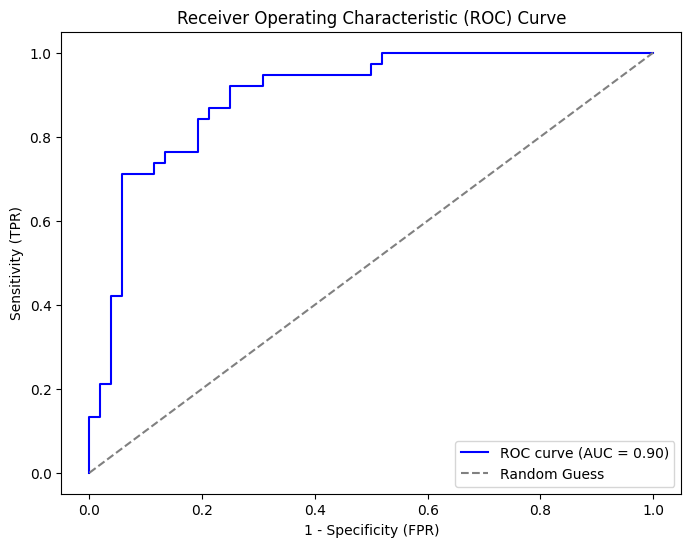

Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: True Story, Predicted: Deceptive Story
Actual: True Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted:

In [42]:
pipeline.enable_nn()
pipeline.disable_rf()
pipeline.disable_knn()
pipeline.evaluate(label_encoder, X_test, y_test)

RF Predictions: [0.25 0.05 0.02 0.24 0.61 0.14 0.97 1.   0.03 0.07 0.76 0.03 0.73 0.04
 0.1  0.07 0.93 0.08 0.81 0.83 0.02 0.04 0.02 0.65 0.15 0.   0.68 0.23
 0.05 1.   0.89 0.61 0.03 0.22 0.83 0.06 0.12 0.03 0.12 0.97 0.46 0.12
 0.97 0.03 0.78 0.93 0.66 0.93 0.68 0.96 0.12 0.85 0.06 0.18 0.   0.03
 0.1  0.04 0.93 0.02 0.3  0.32 0.1  0.49 0.33 0.34 0.98 0.78 0.86 0.75
 0.87 0.01 0.69 0.63 0.57 0.96 0.96 0.92 0.6  0.93 0.15 0.55 0.32 0.01
 0.02 0.03 0.91 0.48 0.54 0.34]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        52
           1       0.93      0.97      0.95        38

    accuracy                           0.96        90
   macro avg       0.95      0.96      0.95        90
weighted avg       0.96      0.96      0.96        90

Confusion Matrix:
 [[49  3]
 [ 1 37]]
Sensitivity: 0.97
Specificity: 0.94
Precision: 0.93
F1 Score: 0.95


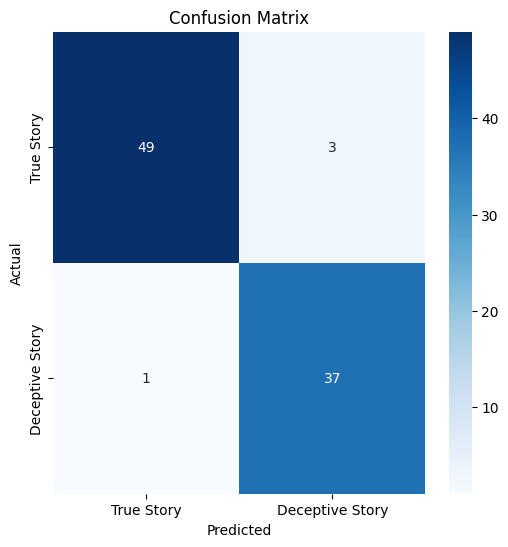

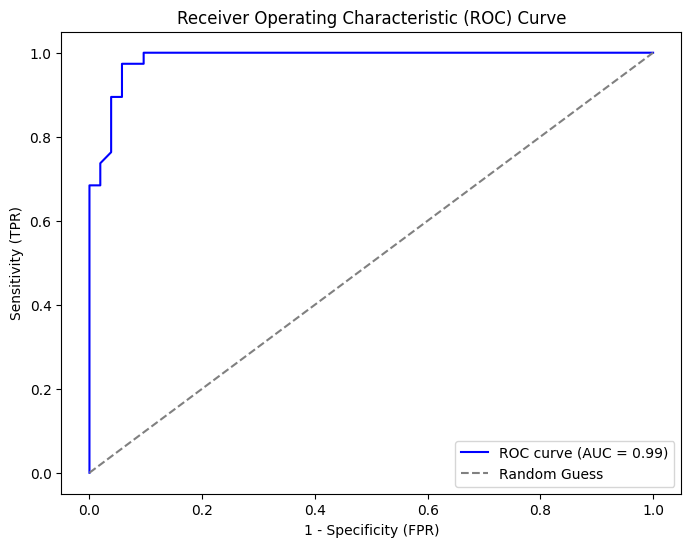

Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Dece

In [43]:
pipeline.disable_nn()
pipeline.enable_rf()
pipeline.disable_knn()
pipeline.evaluate(label_encoder, X_test, y_test)

KNN Predictions: [1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1
 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89        52
           1       0.83      0.89      0.86        38

    accuracy                           0.88        90
   macro avg       0.87      0.88      0.88        90
weighted avg       0.88      0.88      0.88        90

Confusion Matrix:
 [[45  7]
 [ 4 34]]
Sensitivity: 0.89
Specificity: 0.87
Precision: 0.83
F1 Score: 0.86


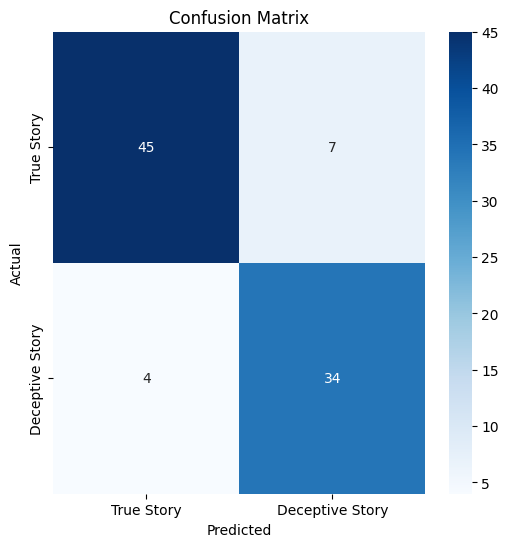

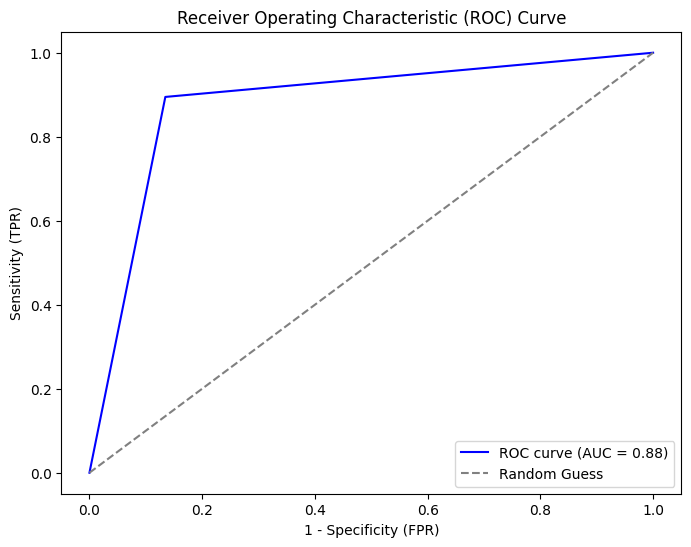

Actual: Deceptive Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive Story
Actual: True Story, Predicted: Deceptive Story
Actual: True Story, Predicted: True Story
Actual: Deceptive Story, Predicted: Deceptive

In [44]:
pipeline.disable_nn()
pipeline.disable_rf()
pipeline.enable_knn()
pipeline.evaluate(label_encoder, X_test, y_test)

# 7 Conclusions

Your conclusions, suggestions for improvements, etc should go here.

# 8 References

Acknowledge others here (books, papers, repositories, libraries, tools) 